# Assignment 2: Social Graphs and Interactions (02805)
### November 5, 2024

**Contributors:**
- Victor Larsen-Saldeen
- Andreas Bardram
- Thomas Schioler Hansen


# Part 1: Genres and communities and plotting
---

**Modularity** is a metric used in network science to measure the strength of division of a network into communities. It reflects the density of links within communities compared to links between communities. If a network has high modularity, it means there are more connections within communities than between them, indicating a stronger community structure.




For a given network partitioned into communities, we compute modularity \( M \) as described in the [Network Science book, Chapter 9, Section 9.4](https://networksciencebook.com/chapter/9#modularity):

$$
M = \sum_{c=1}^{n_c} \left[ \frac{L_c}{L} - \left( \frac{k_c}{2L} \right)^2 \right]
$$

where:

$$
\begin{align*}
L_c &: \text{ the number of links within community } c \\
k_c &: \text{ the sum of degrees of nodes within community } c \\
L &: \text{ the total number of links in the network} \\
n_c &: \text{ the number of communities}
\end{align*}
$$

If \( M > 0 \), the network has a community structure stronger than a randomized configuration, supporting the presence of cohesive groups. Values close to zero or negative suggest no strong community structure.



### Objectives in Part 1
This section aims to explore the alignment between structural communities and genres in a country music network. We will:
1. Calculate modularity for both genre-based and Louvain-detected communities to assess community cohesion.
2. Visualize the network to observe the community structure.
3. Analyze the relationship between communities and genres by creating a confusion matrix for the top genres and communities.





*Note: Analysis in part 1 references concepts from [Section 9.4 of the Network Science book](https://networksciencebook.com/chapter/9).*

In [18]:
import os
import re
import json
import math
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from fa2_modified import ForceAtlas2
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from networkx.algorithms.community import greedy_modularity_communities
import community as community_louvain


In [19]:
def calculate_modularity(G, community_partition):
    m = G.number_of_edges()
    modularity = 0.0

    # Group nodes by community
    communities = {}
    for node, community in community_partition.items():
        if community not in communities:
            communities[community] = set()
        communities[community].add(node)

    # Calculate modularity
    for community_nodes in communities.values():
        k_c = sum(G.degree(node) for node in community_nodes)
        L_c = G.subgraph(community_nodes).number_of_edges()
        modularity += (L_c / m) - (k_c / (2 * m)) ** 2

    return modularity

---

## Step 1: Modularity Calculation for Genre-Based and Louvain Communities

We start by calculating modularity for a genre-based partition using Equation 9.12. This step helps us understand if genres alone form cohesive communities in the network.

In [20]:
G = nx.read_graphml('country_music_graph.graphml')
G = G.to_undirected()

with open('genre.txt', 'r') as f:
    genre_data = json.load(f)


# Create a mapping of nodes to their primary genre (first genre listed)
primary_genre = {artist.replace(' ', '_'): genres[0] for artist, genres in genre_data.items() if genres}

# Assign genres to nodes and filter out those without genre information
nodes_with_genre = {node: primary_genre[node] for node in G.nodes if node in primary_genre}
G_filtered = G.subgraph(nodes_with_genre.keys()).copy()

# Recalculate node degrees and number of edges for the filtered graph
node_degrees = dict(G_filtered.degree())
m = G_filtered.number_of_edges()

# Create a community partition based on genres
community_partition = {node: nodes_with_genre[node] for node in G_filtered.nodes()}

# Calculate modularity using the custom function
modularity_value = calculate_modularity(G_filtered, community_partition)

print(f"The modularity M of the network partitioned by genres is (using eq 9.12): {modularity_value:.4f}")



The modularity M of the network partitioned by genres is (using eq 9.12): 0.0710


**Comment on Output:**

The modularity \( M \) of the network, partitioned by genres and calculated using Equation 9.12, is 0.0710. This low modularity score suggests that genre-based partitions form only weakly cohesive communities, with link density only slightly above random. According to the **Density Hypothesis (H2)** in Section 9.4, this indicates that genre alone may not fully capture the network's community structure, as the intra-community connections do not show strong clustering.

---

## Adjusted Genre-Based Modularity Calculation

To test if different genre assignments affect community cohesion, we adjust each artist's primary genre by selecting the first non-country genre (if available) and then recalculate modularity.


In [21]:
# Adjust genre assignment: Use the first non-country genre if available
adjusted_genre = {}
for artist, genres in genre_data.items():
    artist_name = artist.replace(' ', '_')
    # Assign the first genre that is not "country" if possible
    primary_genre = next((genre for genre in genres if genre != "country"), genres[0])
    adjusted_genre[artist_name] = primary_genre

# Assign genres to nodes and filter out those without genre information
nodes_with_genre = {node: adjusted_genre[node] for node in G.nodes if node in adjusted_genre}
G_filtered = G.subgraph(nodes_with_genre.keys()).copy()

# Recalculate node degrees and number of edges for the filtered graph
node_degrees = dict(G_filtered.degree())
m = G_filtered.number_of_edges()

# Create a community partition based on genres
community_partition = {node: nodes_with_genre[node] for node in G_filtered.nodes()}

# Calculate modularity using the custom function
modularity_value = calculate_modularity(G_filtered, community_partition)

print(f"The modularity M of the network partitioned by adjusted genres is (using eq 9.12): {modularity_value:.4f}")



The modularity M of the network partitioned by adjusted genres is (using eq 9.12): 0.0841


**Comment on Output:**

The modularity \( M \) of the network, partitioned by adjusted genres and calculated using Equation 9.12, is 0.0841. This slight increase in modularity suggests that using the first non-country genre for each artist slightly improves community cohesion, with intra-community links becoming denser. However, the modest gain still indicates that genre alone provides only a limited view of the underlying community structure, supporting the **Density Hypothesis (H2)** that stronger clustering may exist along different network dimensions.


---

## Step 2: Community Detection with the Louvain Algorithm

Using the Louvain algorithm, we aim to detect structural communities in the network by maximizing modularity. This approach allows us to find community structures based on network connectivity rather than predefined genres.


In [28]:
# Detect communities using the Louvain algorithm and calculate modularity
partition = community_louvain.best_partition(G_filtered)

# Calculate modularity using the custom function
modularity_value = calculate_modularity(G_filtered, partition)

print(f"The modularity M of the network partitioned by Louvain algorithm is (using eq 9.12): {modularity_value:.4f}")


The modularity M of the network partitioned by Louvain algorithm is (using eq 9.12): 0.3946


**Comment on Output:**

The Louvain algorithm yields a modularity value close to the optimal community partition, supporting the **Maximal Modularity Hypothesis (H4)**, which posits that partitions with higher modularity values more accurately capture community structure. Louvain's modularity score thus serves as a benchmark for evaluating genre-defined community structures, where deviations suggest a misalignment between genre-based partitions and the network's actual connectivity.


---

## Step 3: Network Visualization with Force Atlas Layout

To visually examine the community structure, we use the Force Atlas 2 layout, coloring nodes by their Louvain-detected communities. This visualization provides insight into the clustering of nodes and the relationships between communities.


100%|██████████| 2000/2000 [00:46<00:00, 42.55it/s]


BarnesHut Approximation  took  10.44  seconds
Repulsion forces  took  34.38  seconds
Gravitational forces  took  0.15  seconds
Attraction forces  took  0.28  seconds
AdjustSpeedAndApplyForces step  took  0.82  seconds


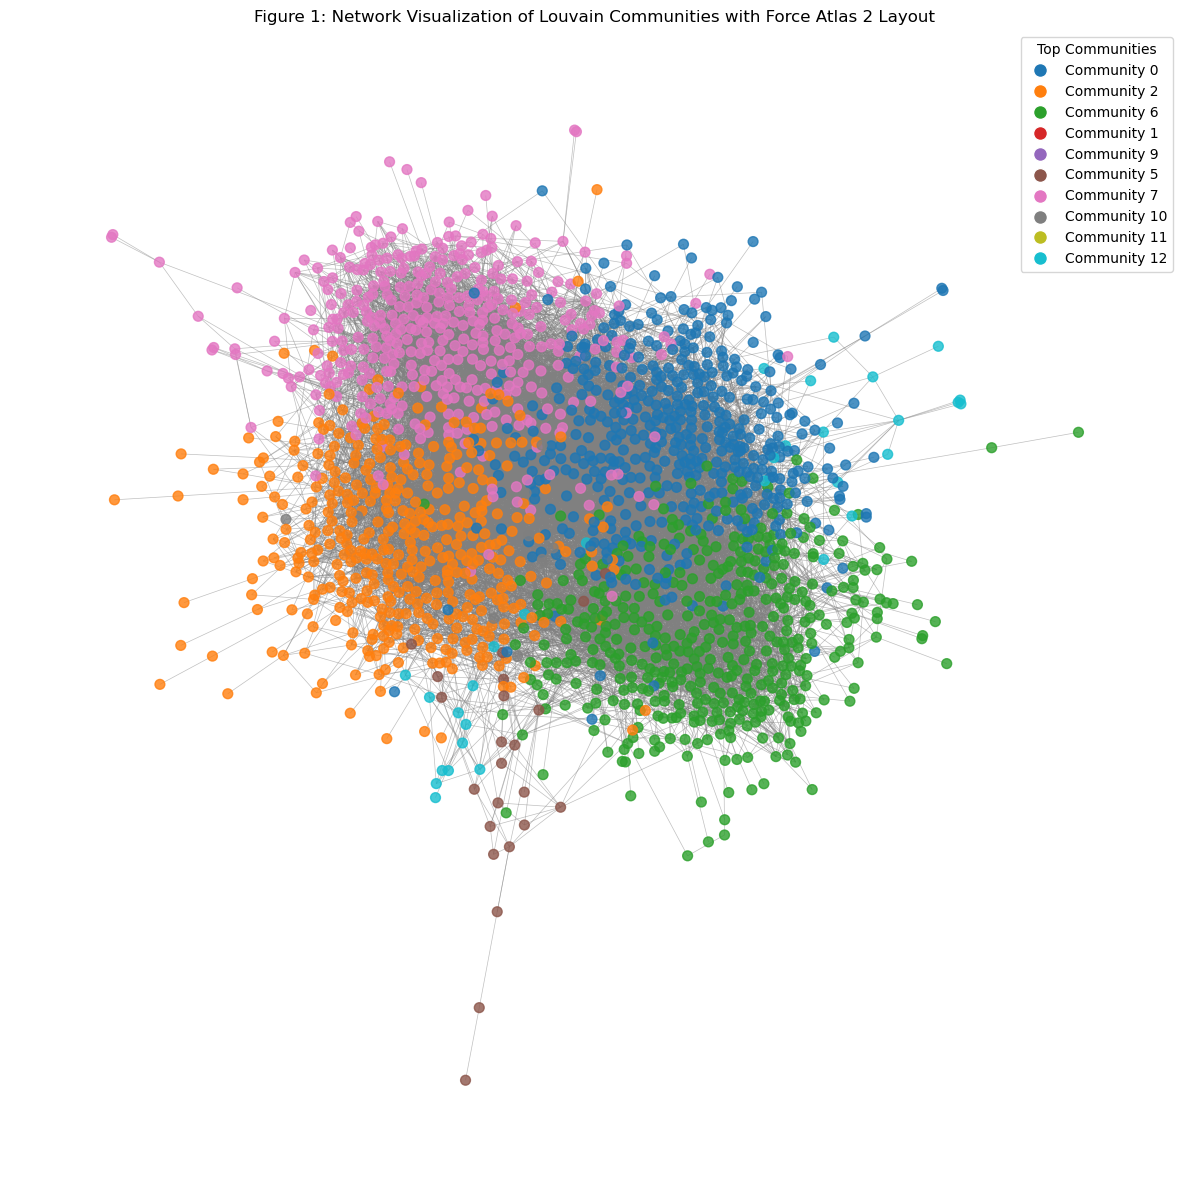

In [31]:
# Prepare genre mapping
artist_genres = {artist.replace(' ', '_'): genres for artist, genres in genre_data.items()}
nodes_with_genre = set(artist_genres.keys())
G_filtered = G.subgraph(nodes_with_genre).copy()

# Remove self-loops
G.remove_edges_from(nx.selfloop_edges(G))

# Remove isolated nodes
isolated_nodes = list(nx.isolates(G_filtered))
G_filtered.remove_nodes_from(isolated_nodes)

# Analyze community structure
community_sizes = Counter(partition.values())
sorted_communities = community_sizes.most_common()

# Prepare visualization with colors for top communities
top_communities = [community for community, size in sorted_communities[:10]]
color_map = plt.get_cmap('tab10')
node_colors = []

for node in G_filtered.nodes():
    community_id = partition[node]
    node_colors.append(color_map(community_id % 10) if community_id in top_communities else 'lightgray')

# Compute Force Atlas 2 layout
forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=False,
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    jitterTolerance=1.0,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    scalingRatio=2.0,
    gravity=1.0,
    verbose=True
)
positions = forceatlas2.forceatlas2_networkx_layout(G_filtered, iterations=2000)

# Draw the network with community colors
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G_filtered, positions, node_size=50, node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(G_filtered, positions, edge_color='gray', alpha=0.5, width=0.5)
plt.axis("off")

# Create legend for top communities
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=f"Community {community}",
               markerfacecolor=color_map(i % 10), markersize=10) 
    for i, (community, _) in enumerate(sorted_communities[:10])
]
plt.legend(handles=handles, loc="best", title="Top Communities")
plt.title("Figure 1: Network Visualization of Louvain Communities with Force Atlas 2 Layout")
plt.tight_layout()
plt.show()




#### Figure 1 Observations:
1. **Community Clustering**: The visualization reveals distinct clusters, indicating strong intra-community links and denser connections within communities. This aligns with the **Maximal Modularity Hypothesis (H4)**, as these partitions demonstrate high modularity scores.
2. **Inter-Community Links**: Sparse connections between clusters suggest limited interaction between different communities, emphasizing modular structure. This sparsity supports the hypothesis that the network has meaningful divisions beyond random connections.
3. **Community Sizes**: Larger communities dominate the structure, as shown by the expansive clusters in prominent colors. Smaller communities are less visually distinct, indicating they may represent more specialized or niche groups within the network.

Overall, this visualization highlights the modular nature of the network, with clear separations that support the Louvain algorithm's community detection results.


---

## Step 4: Community vs. Genre Confusion Matrix

To assess the alignment between genres and detected communities, we create a confusion matrix comparing the top 7 genres and the top 7 communities. This matrix reveals how well the detected communities correspond to genre groupings.


In [30]:
# Collect all genres for each node
node_genres = {artist.replace(' ', '_'): genres for artist, genres in genre_data.items() if genres}
nodes_with_genre = {node: node_genres[node] for node in G.nodes if node in node_genres}
G_filtered = G.subgraph(nodes_with_genre.keys()).copy()
partition = community_louvain.best_partition(G_filtered) 

# Identify top 7 most common genres and top 7 most common communities
all_genres = [genre for genres in node_genres.values() for genre in genres]
top_genres = [genre for genre, _ in Counter(all_genres).most_common(7)]
top_communities = [community for community, _ in Counter(partition.values()).most_common(7)]

# Initialize a confusion matrix with genre names and community IDs
confusion_matrix = pd.DataFrame(0, index=top_genres, columns=top_communities)

# Populate the confusion matrix
for node, genres in nodes_with_genre.items():
    if node in partition:  
        community_id = partition[node]
        if community_id in top_communities:  
            for genre in genres:
                if genre in top_genres:  
                    confusion_matrix.loc[genre, community_id] += 1

# Print
print("Top 7 genres:", top_genres)
print("Top 7 communities (sorted by frequency):", top_communities)
print("\nCommunity vs Genre Confusion Matrix:")
print(confusion_matrix)

Top 7 genres: ['country', 'folk', 'country rock', 'pop', 'americana', 'bluegrass', 'rock']
Top 7 communities (sorted by frequency): [0, 2, 6, 1, 9, 5, 7]

Community vs Genre Confusion Matrix:
                0    2    6    1   9   5  7
country       436  370  362  265  21  21  6
folk           13    8   25  128   0   1  1
country rock   31   55   15   60   6   3  0
pop            23   48   46   33   1   1  4
americana      12   14   12  110   5   1  2
bluegrass      29    9   11   75   0   0  3
rock           21   21   14   56   2   2  0


### Comment
The confusion matrix compares the overlap between genres and communities, revealing patterns in community and genre alignment.

- **Strong Overlap in "Country"**: The "country" genre spans several communities, indicating that country artists form connections across multiple communities.
- **Distinct Genre Clusters**: Genres like "folk" and "americana" have strong concentrations in specific communities, suggesting they align more closely with certain structural clusters.
- **Spread of Pop and Rock**: The "pop" and "rock" genres are more evenly spread across communities, indicating weaker genre-based clustering.

### Conclusion
While there is some alignment between genres and communities, particularly with "country" and "folk," the detected communities do not perfectly align with genre boundaries. This suggests that genre is only one factor influencing community structure, with other network dynamics at play.



---
# Part 2: TF-IDF to understand genres and communities
---

## **Question:** Explain the concept of TF-IDF

**TF-IDF** is a method to assess how important a word is within a specific document relative to an entire collection (corpus). By highlighting terms unique to individual documents, TF-IDF helps identify the distinctive language of genres and communities.

### Formula and Components

The TF-IDF score for a term \( t \) in a document \( d \) is calculated as:

$$\text{TF-IDF}_{t,d} = \text{TF}_{t,d} \times \text{IDF}_t$$

where:
- **TF** measures the importance of a term in a single document.
- **IDF** identifies the term’s rarity across the entire corpus.

### TF

We use **log-normalized TF** instead of raw counts to reduce the impact of very common words. It scales down high counts and gives a more balanced view of term importance:

$$
\text{TF}_{t,d} = 1 + \log(f_{t,d})
$$

This adjustment is useful because raw counts can overemphasize frequent terms, masking less common but potentially meaningful words.

### IDF

**IDF** measures how rare a term is across all documents, enhancing the weight of terms unique to fewer documents. For a term \( t \), the formula is:

$$
\text{IDF}_t = \log\left( \frac{N}{n_t} \right)
$$

- \( N \) is the total number of documents.
- \( $n_t$ \) is the number of documents containing the term \( t \).

By using a larger corpus, IDF identifies terms that stand out in a specific document but are rare across others, making them unique to that document.

### Why Take the Log of IDF?

Taking the log of IDF smooths out the effects of very rare terms, ensuring their weights don’t skew the results too drastically. Without the log, rare terms could dominate the analysis due to excessively high scores.

### How IDF Reduces the Need for Stopword Removal

Since stopwords (e.g., "the," "and") appear in many documents, they naturally receive a low IDF score. This makes them less significant in TF-IDF, reducing the need to explicitly remove them.

### Why TF-IDF Helps in Genre and Community Analysis

1. **Identifying Unique Terms**: TF-IDF pinpoints words unique to each genre or community by emphasizing terms common in one group but rare in others.
2. **Building Community Insights**: High TF-IDF terms reveal unique language and topics, which can be visualized to show what defines each genre or community.
3. **Word Clouds**: Word clouds of high TF-IDF terms offer a clear view of each group’s distinct language.

**In summary**, TF-IDF effectively highlights words that define each genre or community, offering insights into their unique language and themes.


---
## **Question:** Calculate and Visualize TF-IDF for Genres and Communities

### Task Overview
1. **Collect and preprocess text** for each genre and community.
2. **Calculate TF** for words in each genre/community.
3. **Calculate IDF** across all genres/communities.
4. **Compute TF-IDF** for each genre and community.
5. **Visualize results** using word clouds to highlight important words.


In [ ]:

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
unwanted_tokens = {'ref', 'cite', 'center', 'category', 'year', 'row', '2', 'album', 'song', 'music'}

In [5]:


# Preprocess text for a genre
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalnum()]
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word not in unwanted_tokens]
    return tokens

# Aggregate text and build TF list for each genre
def aggregate_tf_for_genre(genre_name, genre_data, artist_folder):
    genre_text = ""
    for artist, genres in genre_data.items():
        if genre_name in genres:
            artist_file = artist.replace(" ", "_") + '.txt'
            artist_path = os.path.join(artist_folder, artist_file)
            if os.path.exists(artist_path):
                with open(artist_path, 'r', encoding='utf-8') as file:
                    genre_text += file.read() + " "

    # Preprocess aggregated text
    tokens = preprocess_text(genre_text)
    tf_list = Counter(tokens)
    
    # Filter rare words
    tf_list_filtered = {word: count for word, count in tf_list.items() if count >= 5}
    
    return tf_list_filtered

# Save TF list for each genre
def save_tf_list(genre_name, tf_list, output_folder):
    file_path = os.path.join(output_folder, f'{genre_name}_tf_list.txt')
    with open(file_path, 'w', encoding='utf-8') as file:
        for word, count in tf_list.items():
            file.write(f"{word} {count}\n")

# Define top 15 genres and data paths
top_genres = ['country', 'folk', 'country rock', 'pop', 'americana', 'bluegrass', 
              'rock', 'country pop', 'gospel', 'rockabilly', 'blues', 
              'alternative country', 'folk rock', 'southern rock', 'rock and roll']
artist_folder = 'country_music_performers'
output_folder = 'tf_lists'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Load genre data
with open('genre.txt', 'r') as file:
    genre_data = json.load(file)

# Generate and save TF lists
for genre in top_genres:
    tf_list = aggregate_tf_for_genre(genre, genre_data, artist_folder)
    save_tf_list(genre, tf_list, output_folder)

# List top 15 words for each genre and add comments
def list_top_15_words(genre_name, tf_list):
    top_15_words = Counter(tf_list).most_common(15)
    print(f"\nTop 15 words for '{genre_name}' genre:")
    for word, count in top_15_words:
        print(f"{word}: {count}")
    print(f"Comment: Words for '{genre_name}' reflect its themes, artist types, or genre-specific details.")
    print("-" * 50)

# Modify this function to accept a list of specific genres to display
def process_top_15_words_for_genres(top_genres, output_folder, genres_to_display=None):
    for genre in top_genres:
        if genres_to_display and genre not in genres_to_display:
            continue  # Skip genres not in the specified list
        file_path = os.path.join(output_folder, f'{genre}_tf_list.txt')
        if os.path.exists(file_path):
            with open(file_path, 'r', encoding='utf-8') as file:
                tf_list = {line.split()[0]: int(line.split()[1]) for line in file}
            list_top_15_words(genre, tf_list)

# Now, specify the genres you want to display
selected_genres = ['country', 'pop']  # You can choose any genres you like
process_top_15_words_for_genres(top_genres, output_folder, genres_to_display=selected_genres)



Top 15 words for 'country' genre:
country: 38571
single: 13485
award: 12775
record: 12767
american: 11228
artist: 9972
released: 9964
chart: 9776
web: 9192
new: 8301
song: 7900
billboard: 7743
first: 7682
magazine: 7311
band: 7244
Comment: Words for 'country' reflect its themes, artist types, or genre-specific details.
--------------------------------------------------

Top 15 words for 'pop' genre:
country: 3788
award: 3579
american: 2635
single: 2612
new: 2566
web: 2539
magazine: 2531
record: 2216
released: 2161
billboard: 2114
http: 2072
artist: 2067
news: 1968
first: 1951
chart: 1859
Comment: Words for 'pop' reflect its themes, artist types, or genre-specific details.
--------------------------------------------------


### Explanation of Each Section

### Text Aggregation
This section collects text data for each artist associated with a genre. For each genre, the code searches within the `country_music_performers` directory, gathers text files related to artists in that genre, and combines them into a single text document. This aggregated text will be used to calculate term frequencies for genre-specific words.

### Text Preprocessing
The `preprocess_text` function standardizes the aggregated text by:
- Tokenizing text into individual words.
- Converting words to lowercase.
- Removing stopwords and specified unwanted tokens (e.g., "ref", "category").
- Lemmatizing each word to its base form.
This ensures that only meaningful words are retained, preparing the data for frequency calculations.

### TF Calculation
After preprocessing, the code calculates the Term Frequency (TF) for each word in the genre’s aggregated text. The `aggregate_tf_for_genre` function uses `Counter` to count occurrences of each word. Words with fewer than 5 occurrences are filtered out to focus on more relevant terms.

### Saving TF Lists
For each genre, the `save_tf_list` function saves the computed TF values to a text file in the `tf_lists` folder. Each file contains words and their counts, representing the most frequent words in that genre.

### Top 15 Words Listing
The `list_top_15_words` function outputs the 15 most frequent words for each genre, showing key terms that characterize the genre’s themes, artist styles, or unique details. Each word’s frequency count is displayed, along with a comment about the genre’s language.

### Usage
- **Text Files**: Ensure each artist’s Wikipedia page text is saved in `.txt` format in the `country_music_performers` directory.
- **Output**: TF lists are saved in the `tf_lists` folder, and the top 15 words for each genre are printed to the console with additional commentary.


## Explanation for the code below:

- **TF Calculation**: Uses log-scaling on counts for each word in each genre document.
- **IDF Calculation**: Computes IDF using the unique word counts across all genre documents.
- **TF-IDF Calculation**: Multiplies TF by IDF for each word to get TF-IDF scores.
- **Top Words Table**: Creates a DataFrame of the top 10 TF-IDF words for each genre.
- **Word Cloud Visualization**: Generates a word cloud for each genre, highlighting unique and frequent terms.

### Calculation of TF-IDF for Each Genre and Community
The code calculates TF-IDF scores for each word in each genre, focusing on meaningful, non-numeric words.

### Visualization Using Word Clouds
Word clouds for each genre are generated, visually highlighting the words with the highest TF-IDF scores. This helps illustrate which words are most unique to each genre or community.


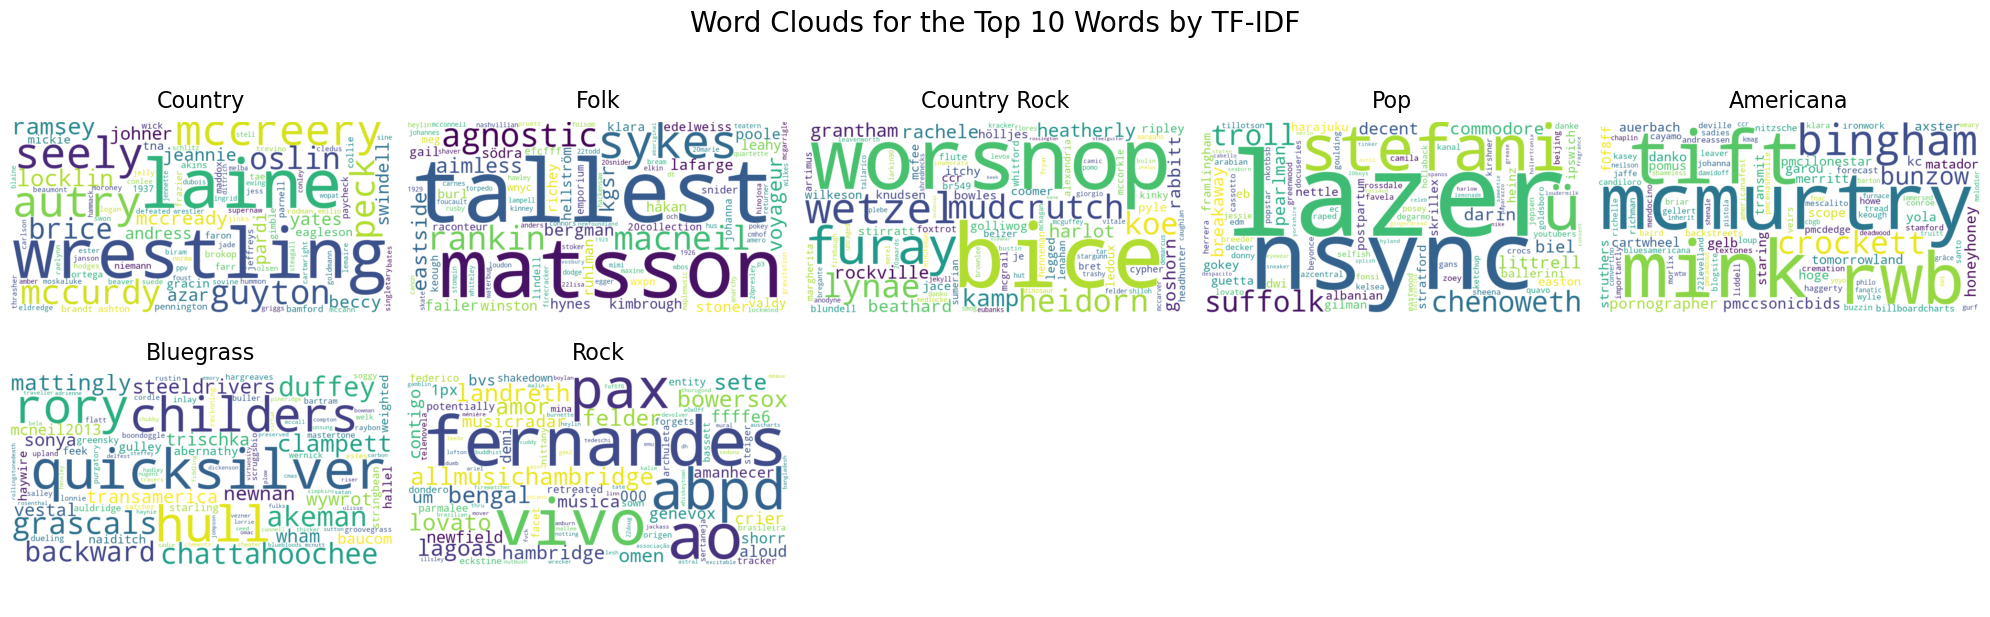

In [ ]:

# Load TF lists and reconstruct TF dictionaries
tf_by_genre = {}
for genre in top_genres:
    filename = f'tf_lists/{genre}_tf_list.txt'
    tf_dict = {}
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            word, count = line.strip().split()
            tf_dict[word] = 1 + math.log(int(count))
    tf_by_genre[genre] = tf_dict

# Calculate IDF across all genres
total_documents = len(tf_by_genre)
df_counts = Counter()
for tf_dict in tf_by_genre.values():
    unique_words = set(tf_dict.keys())
    for word in unique_words:
        df_counts[word] += 1

idf = {word: math.log(total_documents / df_count) for word, df_count in df_counts.items()}

# Calculate TF-IDF
tfidf_by_genre = {}
for genre, tf_values in tf_by_genre.items():
    tfidf_by_genre[genre] = {word: tf * idf[word] for word, tf in tf_values.items()}

# Get top 10 TF-IDF words for each genre
top_words_by_genre = {}
for genre, tfidf in tfidf_by_genre.items():
    sorted_tfidf = sorted(tfidf.items(), key=lambda x: x[1], reverse=True)
    top_words = sorted_tfidf[:10]
    top_words_by_genre[genre] = top_words

# Prepare data for display
table_data = []
for genre, words in top_words_by_genre.items():
    words = [f"{word} ({score:.2f})" for word, score in words]
    table_data.append(words)
df = pd.DataFrame(table_data, index=[genre.title() for genre in top_words_by_genre],
                  columns=[f"Word #{i+1}" for i in range(10)])

# print(df)

# Create word clouds
num_genres = len(tf_by_genre)
num_cols = 5
num_rows = math.ceil(num_genres / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 3))
axes = axes.flatten()

for idx, (genre, tfidf_scores) in enumerate(tfidf_by_genre.items()):
    ax = axes[idx]
    # Get the top TF-IDF scores for the word cloud
    top_tfidf_scores = dict(sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)[:100])
    wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False)
    wordcloud.generate_from_frequencies(top_tfidf_scores)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(genre.title(), fontsize=16, pad=10)

for idx in range(len(tfidf_by_genre), len(axes)):
    axes[idx].axis('off')

fig.suptitle('Word Clouds for the Top 10 Words by TF-IDF', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()



## Explanation of Code below

- **Adjust Text Aggregation**: Aggregate text data based on structural communities instead of genres.
- **Calculate TF**: For each community, calculate TF for words using tokenization, filtering, and log-scaling.
- **Calculate IDF**: IDF remains the same as previously calculated, considering words across all communities.
- **Compute TF-IDF**: For each community, calculate TF-IDF by multiplying TF and IDF for each word.
- **Top Words Table and Word Cloud Visualization**: Generate a table and word clouds displaying the top TF-IDF words for each community.
- **Analyze and Compare Word Clouds**: Compare community word clouds with genre word clouds using matrix \( D \) for alignment analysis.


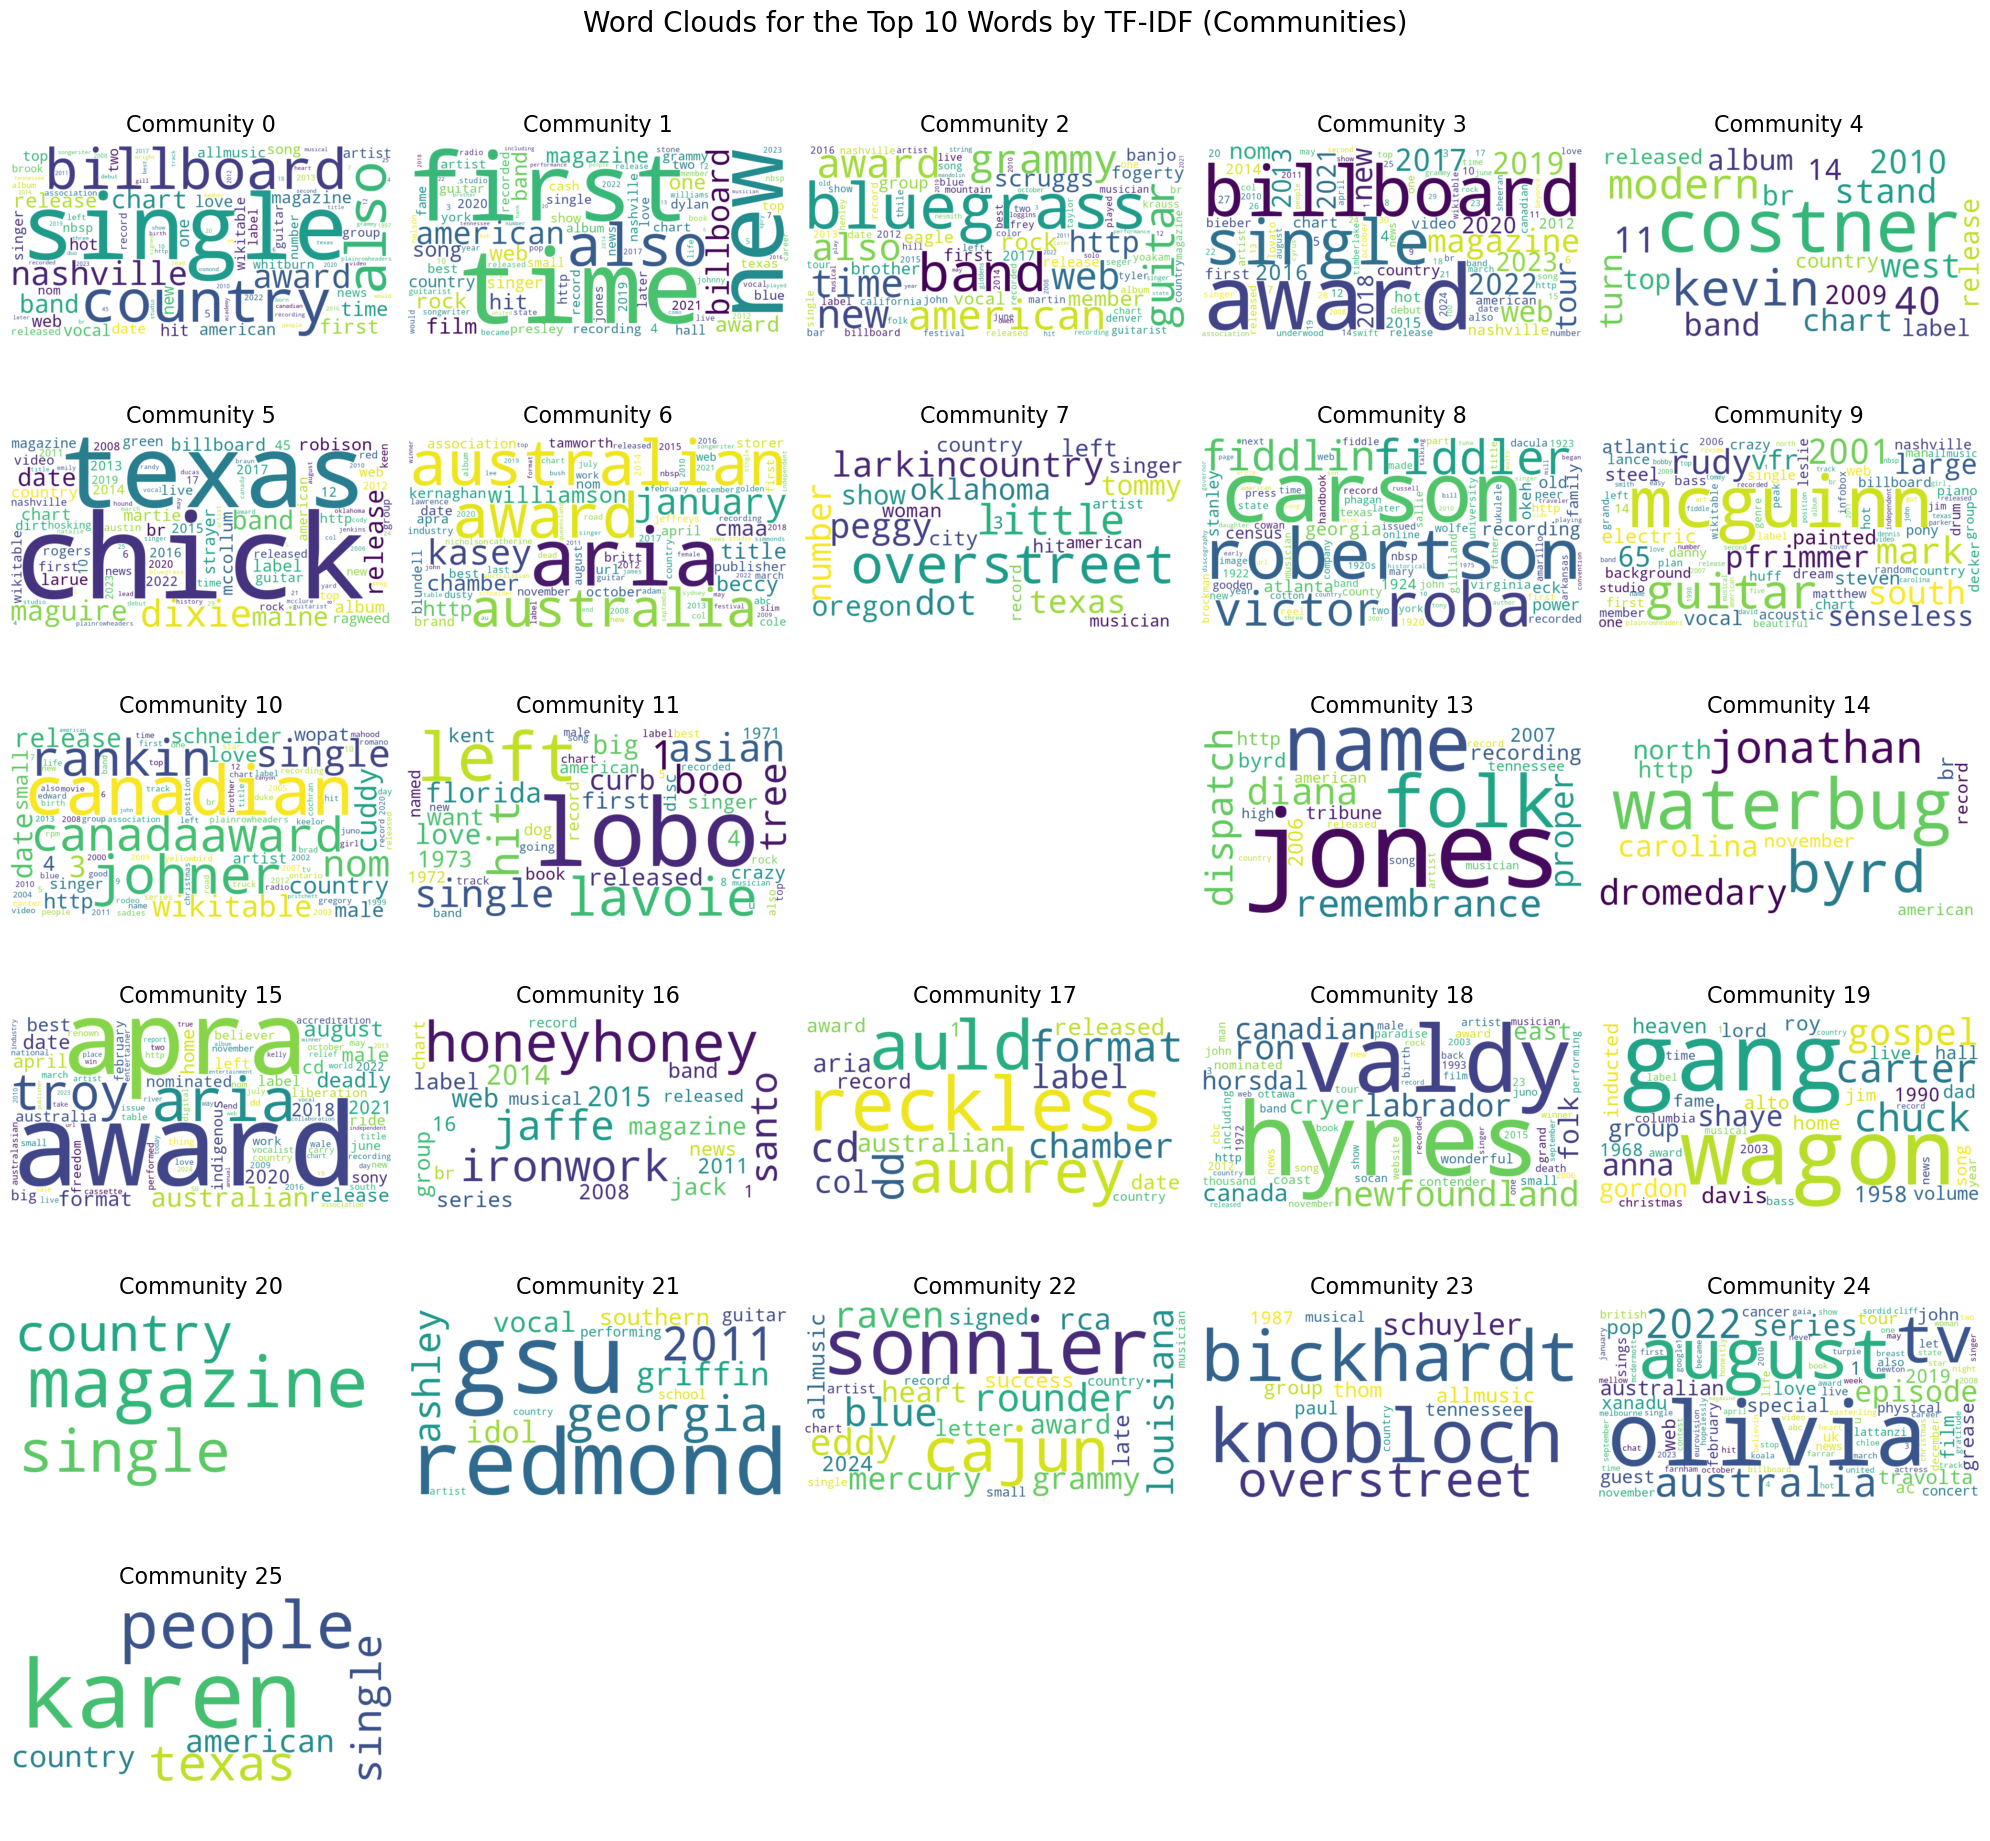

In [ ]:

# Initialize tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
unwanted_tokens = {'ref', 'cite', 'center', 'category', 'year', 'row', '2', 'album', 'song', 'music'}

# Preprocess text for a community
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalnum()]
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word not in unwanted_tokens]
    return tokens

# TF list for each structural community
def aggregate_tf_for_community(community_id, partition, artist_folder, genre_data):
    community_text = ""
    for artist, comm_id in partition.items():
        if comm_id == community_id:
            artist_file = artist.replace(" ", "_") + '.txt'
            artist_path = os.path.join(artist_folder, artist_file)
            if os.path.exists(artist_path):
                with open(artist_path, 'r', encoding='utf-8') as file:
                    community_text += file.read() + " "

    tokens = preprocess_text(community_text)
    tf_list = Counter(tokens)
    
    tf_list_filtered = {word: count for word, count in tf_list.items() if count >= 5}
    
    return tf_list_filtered

artist_folder = 'country_music_performers'
output_folder = 'tf_lists_communities'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open('genre.txt', 'r') as file:
    genre_data = json.load(file)

community_tf_lists = {}
for community_id in set(partition.values()):
    tf_list = aggregate_tf_for_community(community_id, partition, artist_folder, genre_data)
    community_tf_lists[community_id] = tf_list

# Calculate IDF (same as before)
total_documents = len(community_tf_lists)
df_counts = Counter()
for tf_list in community_tf_lists.values():
    unique_words = set(tf_list.keys())
    for word in unique_words:
        df_counts[word] += 1

idf = {word: math.log(total_documents / df_count) for word, df_count in df_counts.items()}

# Calculate TF-IDF
tfidf_by_community = {}
for community_id, tf_list in community_tf_lists.items():
    tfidf_by_community[community_id] = {word: tf * idf[word] for word, tf in tf_list.items()}

# top 10 TF-IDF words for each community
top_words_by_community = {}
for community_id, tfidf in tfidf_by_community.items():
    sorted_tfidf = sorted(tfidf.items(), key=lambda x: x[1], reverse=True)
    top_words = sorted_tfidf[:10]
    top_words_by_community[community_id] = top_words

table_data = []
for community_id, words in top_words_by_community.items():
    words = [f"{word} ({score:.2f})" for word, score in words]
    table_data.append(words)
df = pd.DataFrame(table_data, index=[f"Community {community_id}" for community_id in top_words_by_community],
                  columns=[f"Word #{i+1}" for i in range(10)])

# print("Top 10 TF-IDF Words for Each Structural Community")
# print(df)

# Create word clouds
num_communities = len(tfidf_by_community)
num_cols = 5
num_rows = math.ceil(num_communities / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 3))
axes = axes.flatten()

for idx, (community_id, tfidf_scores) in enumerate(tfidf_by_community.items()):
    top_tfidf_scores = dict(sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)[:100])
    
    if top_tfidf_scores:  # Check if there are words to plot
        ax = axes[idx]
        wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False)
        wordcloud.generate_from_frequencies(top_tfidf_scores)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(f"Community {community_id}", fontsize=16, pad=10)
    else:
        axes[idx].axis('off')

for idx in range(len(tfidf_by_community), len(axes)):
    axes[idx].axis('off')

fig.suptitle('Word Clouds for the Top 10 Words by TF-IDF (Communities)', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()



## **Question:** Comparison of Word Clouds Between Genres and Communities Using Matrix \( D \)

The genre word clouds show unique terms for each genre. For example, the "Pop" genre word cloud features artists like "stefani" and "lovato," highlighting key pop artists.

In contrast, the community word clouds (Figures 16-36) often display general industry terms like "single," "award," and "billboard" (e.g., Community 0). Some communities highlight regional associations, such as "texas" in Community 3.

**Key Observations from TF-IDF Tables and Word Clouds:**

Genre word clouds emphasize specific artists and terms related to that genre. For instance, the "Rock" genre includes "parmalee" and "bengal," representing artists in rock music.

Community word clouds frequently feature terms about industry success or locations. Community 4's top words include "award," "billboard," and "bieber," suggesting a focus on commercially successful artists across genres.

**Using Matrix \( D \) to Compare Genre and Community Alignment:**

The confusion matrix \( D \) shows the overlap between top genres and communities. While some genres have higher counts in certain communities, the overall alignment is not strong.

For example, the "Country" genre's artists are spread across multiple communities. This indicates that country artists are distributed throughout the network's structural communities.

**Concrete Examples:**

Community 3: Terms like "texas," "ragweed," and "maine" suggest this community represents artists from Texas or involved in Texas country music, which may not align perfectly with genre classifications.

Community 5: The prominence of "canadian," "yellowbird," and "mahood" indicates a community of Canadian artists, possibly spanning genres like Country and Folk.



The word clouds and confusion matrix show that while genres capture stylistic similarities, the structural communities may be influenced by other factors like geography, collaborations, and commercial success. This suggests that communities encompass relationships beyond genre alone.


---
# Part 3: Sentiment of the artists and communities
---

In [28]:

# Load the LabMT word list into a dictionary for use in sentiment analysis
def load_labmt_wordlist(file_path):

    column_names = ['word', 'happiness_rank', 'happiness_average', 'happiness_standard_deviation',
                    'twitter_rank', 'google_rank', 'nyt_rank', 'lyrics_rank']
    
    labmt_data = pd.read_csv(file_path, sep='\t', skiprows=2, names=column_names)
    labmt_data['happiness_average'] = pd.to_numeric(labmt_data['happiness_average'], errors='coerce')
    labmt_data = labmt_data.dropna(subset=['happiness_average'])
    
    happiness_dict = dict(zip(labmt_data['word'], labmt_data['happiness_average']))
    return happiness_dict

# Function to calculate sentiment score using LabMT word list
def calculate_sentiment(tokens, happiness_dict, neutral_threshold=5.0):
    scores = []
    for token in tokens:
        score = happiness_dict.get(token)
        if score and abs(score - neutral_threshold) > 1.0:
            scores.append(score)
    
    return sum(scores) / len(scores) if scores else None

# Function to tokenize the text 
def tokenize_text(text):
    tokens = re.findall(r'\b\w+\b', text.lower())
    return tokens

# Function to calculate sentiment for each artist's page
def calculate_artist_sentiments(directory_path, happiness_dict):
    artist_sentiments = {}
    
    for filename in os.listdir(directory_path):
        if filename.endswith(".txt"): 
            file_path = os.path.join(directory_path, filename)
            
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()
                
            tokens = tokenize_text(text)
            
            sentiment_score = calculate_sentiment(tokens, happiness_dict)
            
            artist_sentiments[filename] = sentiment_score
    
    return artist_sentiments

file_path = 'labMIT-1.0.txt'

happiness_dict = load_labmt_wordlist(file_path)

directory_path = 'country_music_performers'

artist_sentiments = calculate_artist_sentiments(directory_path, happiness_dict)

# Display the first 5 sentiment scores
for i, (artist, sentiment) in enumerate(artist_sentiments.items()):
    if i >= 5:
        break
    print(f"{artist}: {sentiment}")


Harry_McClintock.txt: 6.406433734939756
Haley_&_Michaels.txt: 6.630117647058822
Dickey_Betts.txt: 6.254839924670439
Two_Tons_of_Steel.txt: 6.522873563218388
Bacon_Brothers.txt: 6.98


### Description of Initial Sentiment Analysis Findings for Country Music Artist Profiles

We have used the LabMT word list, and calculated sentiment scores for a collection of country music artist profiles. The code shown above will:

1. Load the LabMT word list, mapping each word to its happiness score.
2. Process each token, checking if it exists in the LabMT list.
3. Sum the happiness scores for tokens that are present in the list and calculate an average score.

Next up, we will calculate average, mean, variance, 25th percentile and 75th percentile to get a better overview of the sentiment scores for the entire collection of country music artist profiles:

In [30]:

# Calculate average, mean, variance, 25th percentile and 75th percentile
def calculate_statistics(artist_sentiments):
    sentiment_scores = [score for score in artist_sentiments.values() if score is not None]
    
    if len(sentiment_scores) == 0:
        return {
            "average": None,
            "median": None,
            "variance": None,
            "25th_percentile": None,
            "75th_percentile": None
        }
    
    average_sentiment = np.mean(sentiment_scores)
    median_sentiment = np.median(sentiment_scores)
    variance_sentiment = np.var(sentiment_scores)
    percentile_25 = np.percentile(sentiment_scores, 25)
    percentile_75 = np.percentile(sentiment_scores, 75)
    
    return {
        "average": average_sentiment,
        "median": median_sentiment,
        "variance": variance_sentiment,
        "25th_percentile": percentile_25,
        "75th_percentile": percentile_75
    }

# Calculate statistics for the sentiment scores
statistics = calculate_statistics(artist_sentiments)

# Display 
statistics


{'average': 6.3995517311408285,
 'median': 6.413586206896536,
 'variance': 0.04319745655306958,
 '25th_percentile': 6.321995498874737,
 '75th_percentile': 6.497872340425527}

### Description of Average, Mean, Variance, 25th percentile and 75th percentile Sentiment across All The Profiles

We can see that the sentiment scores in general fall within the same range. Most Profiles are around 6.321995498874737 and 6.497872340425527 with a median of 6.413586206896536 and a average of 6.3995517311408285. We have very little variance, with a variance of only: 0.04319745655306958, which indicates that generally these profile pages are written in the same tone. 

These numbers tell us that most profiles have slightly positive tone. In this context, words reflecting everyday positivity, such as “good,” “music,” and “success,” tend to push sentiment scores to around 6, which is where pretty much all our sentiment scores are. This makes sense since artist pages often employ language that focus on career highlights, achievements, and the appealing qualities of each artist, with very little critisicm and negative sentences.

The very minimal variation indicate that most profile pages are written in a similair tone, with only slight differences. The median is close to the mean, suggesting a symmetric distribution of sentiment scores, with most profiles slightly above neutral. The 25th and 75th percentiles reveal a narrow interquartile range, meaning there is little variation between the sentiment of different profiles. 

We will now create a histogram to give a visual representation of the distribution of the sentiment scores.

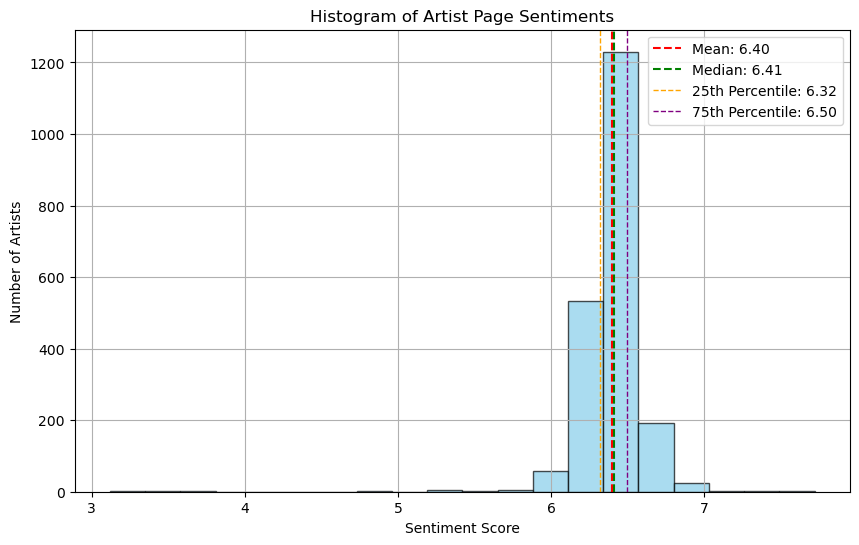

In [34]:
# Extract sentiment scores for histogram
sentiment_scores = [G.nodes[performer].get('sentiment') for performer in G.nodes if G.nodes[performer].get('sentiment') is not None]

mean_sentiment = np.mean(sentiment_scores)
median_sentiment = np.median(sentiment_scores)
percentile_25 = np.percentile(sentiment_scores, 25)
percentile_75 = np.percentile(sentiment_scores, 75)

# Plot histogram of sentiment scores
plt.figure(figsize=(10, 6))
plt.hist(sentiment_scores, bins=20, color='skyblue', edgecolor='black', alpha=0.7)

# Add mean and median lines
plt.axvline(mean_sentiment, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_sentiment:.2f}')
plt.axvline(median_sentiment, color='green', linestyle='dashed', linewidth=1.5, label=f'Median: {median_sentiment:.2f}')

# Add percentile lines
plt.axvline(percentile_25, color='orange', linestyle='dashed', linewidth=1, label=f'25th Percentile: {percentile_25:.2f}')
plt.axvline(percentile_75, color='purple', linestyle='dashed', linewidth=1, label=f'75th Percentile: {percentile_75:.2f}')

# Add title, labels, legend, and grid
plt.title('Histogram of Artist Page Sentiments')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Artists')
plt.legend()
plt.grid(True)
plt.show()


### Description of Histogram of Sentiment Score

Here we see a very narrow distribution again with little variance, where pretty much all profile pages have a sentiment score of 6-7. We have a few outliers though, which both could indicate that some profile pages are written in a very negative tone or very positive tone, but when having such extreme outliers like here, it could also indicate that in the dataset there are profile pages with very few words, thus resulting in extreme results. 

Next we will take a look at these more extreme cases by looking at the 10 saddest and 10 happiest pages:

In [36]:
# Get the 10 saddest pages of performers and the 10 happiest pages of performers
performer_sentiments = {node: G.nodes[node]['sentiment'] for node in G.nodes if G.nodes[node].get('sentiment') is not None}
sorted_performers = sorted(performer_sentiments.items(), key=lambda x: x[1])
saddest_performers = sorted_performers[:10]
happiest_performers = sorted_performers[-10:]

print("10 saddest pages of performers:")
for performer, sentiment in saddest_performers:
    print(f"{performer}: {sentiment}")

print("\n10 happiest pages of performers:")
for performer, sentiment in happiest_performers:
    print(f"{performer}: {sentiment}")


10 saddest pages of performers:
Cole_Deggs_&_The_Lonesome: 3.12
Mats_Radberg: 3.54
Brian_Kelley_(musician): 3.78
Jimmie_Rodgers_(country_singer): 3.78
Kerry_Harvick: 4.79
Riley_Green_(singer): 5.28
Bill_'Cowboy_Rambler'_Boyd: 5.3100000000000005
Those_Poor_Bastards: 5.3107801418439715
Love_and_Theft_(band): 5.359999999999999
Bobby_Cash_(singer): 5.6

10 happiest pages of performers:
Donny_Parenteau: 6.836616438356158
Soggy_Bottom_Boys: 6.91
Girls_Next_Door_(band): 6.94
The_JaneDear_Girls: 6.94
Brad_Johner: 6.940273224043699
Bacon_Brothers: 6.98
Carl_Smith_(country_musician): 6.98
Amazing_Rhythm_Aces: 7.155
Dick_Feller: 7.32
The_Carter_Family: 7.72


### Description of Top 10 Happiest and Saddest Performers

Here we get a good look at the outliers, and as we can see here it's only very few wikis with low and high sentiment scores compared to the almost 2000 wikis centered around the 6-7 range, so we have a very center heavy distribution.

Next we will try to divide the profile pages into communities:

### Description of Sentiment Analysis

The sentiment analysis shows a consistent, mildly positive tone across the largest communities, with average sentiment scores clustering around 6.4. Larger communities reflect mainstream themes in country music, maintaining a moderate positivity, while smaller communities show slight variations, possibly due to unique or niche topics. 

### Do the findings using TF-IDF during Lecture 7 help you understand your results?

**Yes**. The important words identified by TF-IDF in each community influence the sentiment scores of their artist pages.

**Connection Between TF-IDF and Sentiment:**

- Positive Words Increase Sentiment Scores: Communities with words like "award," "success," and "hit" often have higher sentiment scores. These words carry positive emotions, boosting the average sentiment of the community's pages.

- Theme-Based Variations: Some communities focus on specific themes like regions ("Texas," "Canadian") or genres. These themes bring in unique words that affect sentiment differently.

- Consistent Language Patterns: The TF-IDF analysis shows that many communities share common industry terms. This consistency leads to similar sentiment scores across communities.

**Examples:**

- Community with High Sentiment: A community where TF-IDF highlights words like "award" and "billboard" tends to have higher sentiment scores due to the positive nature of these words.

- Community with Neutral Sentiment: A community focused on geographical terms may have sentiment scores closer to the average, as location words are often neutral.

